In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/privacy_permutation/')

Mounted at /content/drive


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader,Subset

from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import scipy.signal as signal

import utils

# %matplotlib widget
%matplotlib notebook
%matplotlib inline

<ipython-input-2-d675b14681c7>:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
utils.setup_seed(1312)

In [ ]:
img_size = 33

test = utils.Permutar(img_size, 1)
test.key

array([608, 275, 171, ..., 791, 176,  81])

dataloader

In [ ]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform=transforms.Compose([
    T.Resize((33,33)),
    T.ToTensor(),
    T.Normalize((0.1307,), (0.3081,))
    ])

trainset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform,)
testset = datasets.FashionMNIST(root='data',
                                train=False, download=True, transform=transform)

fake_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, drop_last=True)
r = list(fake_loader)

images = torch.tensor([])
labels = torch.tensor([])

for i,a in enumerate(r):
  test = utils.Permutar(33,1)
  image_batch = test.desordenar(a[0])
  images = torch.cat((images, image_batch)) if images.shape[0] > 1 else image_batch
  labels = torch.cat((labels, a[1])) if labels.shape[0] > 1 else a[1]


trainset_disorderly = torch.utils.data.TensorDataset(images,labels)

train_loader = torch.utils.data.DataLoader(trainset_disorderly, batch_size=64, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, drop_last=True)

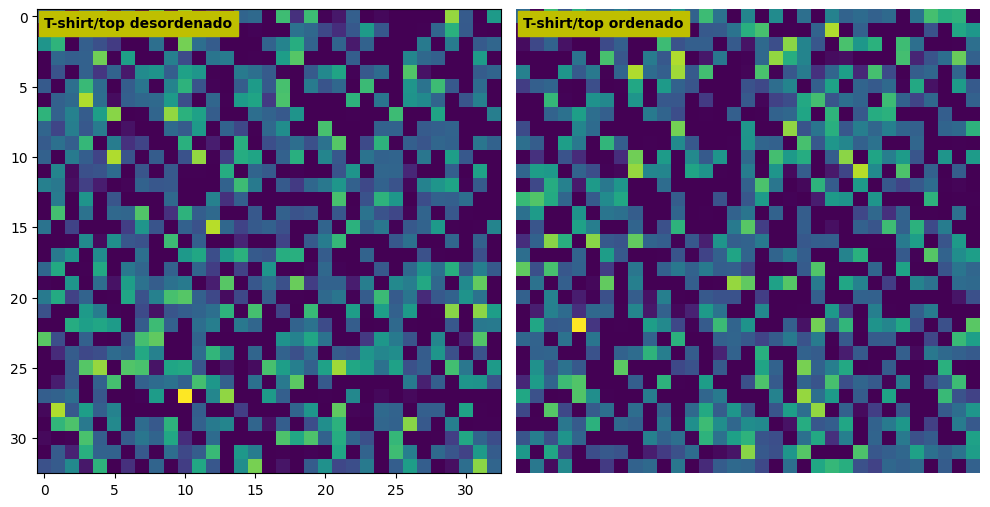

In [ ]:
a = next(iter(train_loader))
X,y = [a[0][0], a[1][0]]
fig,axs = plt.subplots(1,2,figsize=(10,10))

pic = X.data.cpu().numpy().transpose((1,2,0))
pic = pic-np.min(pic) # undo normalization
pic = pic/np.max(pic)

label = testset.classes[y]

axs[0].imshow(pic)
axs[0].text(0,0,f'{label} desordenado',ha='left',va='top',fontweight='bold',color='k',backgroundcolor='y')

plt.axis('off')

plt.tight_layout()
plt.show()

### network

In [ ]:
from permuted_newtork import PermutedNetwork_2 as PermutedNetwork

model = PermutedNetwork().to(device)

In [ ]:
#model.load_state_dict(torch.load('model_weights.pth'), strict=False)

In [ ]:
summary(model, (1, 33, 33))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 33, 33]             180
      DeformConv2d-2           [-1, 16, 33, 33]             160
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 18, 16, 16]           2,610
      DeformConv2d-5           [-1, 32, 16, 16]           4,640
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 18, 8, 8]           5,202
      DeformConv2d-8             [-1, 16, 8, 8]           4,624
 AdaptiveAvgPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                   [-1, 10]             170
Total params: 17,586
Trainable params: 17,586
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.07
Estimated Tot

In [ ]:
#model.conv1.requires_grad_(False)
#model.conv2.requires_grad_(False)
#model.conv3.requires_grad_(False)
#model.conv4.requires_grad_(False)
#model.conv5.requires_grad_(False)
#model.conv6.requires_grad_(False)

In [ ]:
# Define the loss
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:


# Train the network
epochs = 50

trainLoss = torch.zeros(epochs)
testLoss  = torch.zeros(epochs)
trainAcc  = torch.zeros(epochs)
testAcc   = torch.zeros(epochs)

for e in range(epochs):
    model.train()
    batchLoss = []
    batchAcc  = []
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        batchAcc.append((output.argmax(dim=1) == labels).type(torch.float).mean())

    trainLoss[e] = torch.tensor(batchLoss).mean()
    trainAcc[e]  = torch.tensor(batchAcc).mean()

    model.eval()
    batchLoss = []
    batchAcc  = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device) #test.desordenar(images).to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            batchLoss.append(loss.item())
            batchAcc.append((output.argmax(dim=1) == labels).type(torch.float).mean())

    testLoss[e] = torch.tensor(batchLoss).mean()
    testAcc[e]  = torch.tensor(batchAcc).mean()

    print(f"Epoch {e+1}/{epochs} Test Loss: {testLoss[e]:.3f} Test Acc: {testAcc[e]:.3f}, Train Loss: {trainLoss[e]:.3f} Train Acc: {trainAcc[e]:.3f}")



Epoch 1/50 Test Loss: 4.318 Test Acc: 0.121, Train Loss: 1.668 Train Acc: 0.337
Epoch 2/50 Test Loss: 3.947 Test Acc: 0.122, Train Loss: 1.649 Train Acc: 0.341
Epoch 3/50 Test Loss: 4.177 Test Acc: 0.119, Train Loss: 1.639 Train Acc: 0.346
Epoch 4/50 Test Loss: 4.153 Test Acc: 0.101, Train Loss: 1.634 Train Acc: 0.347
Epoch 5/50 Test Loss: 4.106 Test Acc: 0.116, Train Loss: 1.629 Train Acc: 0.347
Epoch 6/50 Test Loss: 3.898 Test Acc: 0.123, Train Loss: 1.623 Train Acc: 0.349
Epoch 7/50 Test Loss: 3.659 Test Acc: 0.106, Train Loss: 1.616 Train Acc: 0.353
Epoch 8/50 Test Loss: 3.506 Test Acc: 0.114, Train Loss: 1.612 Train Acc: 0.354
Epoch 9/50 Test Loss: 3.112 Test Acc: 0.123, Train Loss: 1.606 Train Acc: 0.356
Epoch 10/50 Test Loss: 3.376 Test Acc: 0.124, Train Loss: 1.598 Train Acc: 0.362
Epoch 11/50 Test Loss: 3.608 Test Acc: 0.116, Train Loss: 1.593 Train Acc: 0.365
Epoch 12/50 Test Loss: 3.304 Test Acc: 0.120, Train Loss: 1.583 Train Acc: 0.371
Epoch 13/50 Test Loss: 2.899 Test Acc

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (croos entropy)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('network on mnist',fontweight='bold',fontsize=14)
plt.show()

In [ ]:
X,y = next(iter(test_loader))

X = test.desordenar(X).to(device)
y = y.to(device)


predictions = torch.argmax( model(X) ,axis=1)


fig,axs = plt.subplots(4,4,figsize=(10,10))

for (i,ax) in enumerate(axs.flatten()):

  pic = X.data[i].cpu().numpy().transpose((1,2,0))
  pic = pic-np.min(pic) # undo normalization
  pic = pic/np.max(pic)

  ax.imshow(pic, cmap='gray')


  # label and true class
  #print(i)
  label = trainset.classes[predictions[i]]
  truec = trainset.classes[y[i]]
  title = f'Pred: {label}  -  true: {truec}'

  # set the title with color-coded accuracy
  titlecolor = 'g' if truec==label else 'r'
  ax.text(15,32,title,ha='center',va='top',fontweight='bold',color='k',backgroundcolor=titlecolor,fontsize=8)
  ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# test
model.eval()
batchLoss = []
batchAcc  = []

with torch.no_grad():
    for images, labels in test_loader:
        images = test.desordenar(images).to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        batchLoss.append(loss.item())
        batchAcc.append((output.argmax(dim=1) == labels).type(torch.float).mean())

testLoss = torch.tensor(batchLoss).mean()
testAcc  = torch.tensor(batchAcc).mean()

print(testLoss,testAcc)

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')